In [ ]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

### Read entire ANSI/AAMI EC13 Test Waveforms dataset

In [2]:
datasetPath = r"C:\Users\USER\Documents\SLIIT\Datasets\ansiaami-ec13-test-waveforms-1.0.0\ansiaami-ec13-test-waveforms-1.0.0"

In [3]:
def printECGDetails(record):
    if not hasattr(record, 'fs'):
        print(f"Sampling frequency: " + str(record.get('fs')) + " Hz")
        print(f"Number of channels: " + str(record.get('n_sig')) + "")
        print(f"Signal name: " + str(record.get('sig_name')) + "")
        print(f"Signal comments: " + str(record.get('comments')) + "\n")        
    else:
        print(f"Sampling frequency: {record.fs} Hz")
        print(f"Number of channels: {record.n_sig}")
        print(f"Signal name: {record.sig_name}")
        print(f"Signal shape: {record.p_signal.shape}")
        print(f"Signal comments: {record.comments}\n")
        
def plotECGSignal(data):
    plt.plot(data, label='ECG signal')
    plt.show()

Record: aami3a
Sampling frequency: 720 Hz
Number of channels: 1
Signal name: ['ECG']
Signal comments: ['ANSI/AAMI EC13-1992, Figure 3a.']



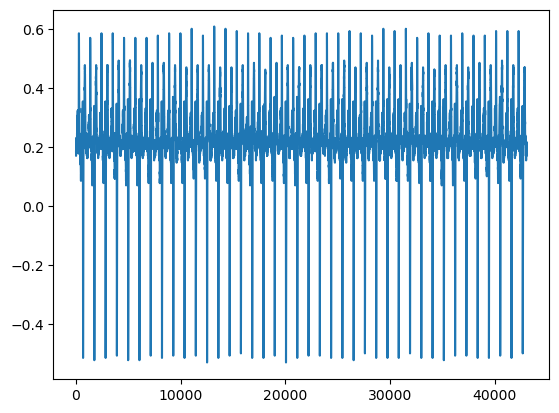

Record: aami3b
Sampling frequency: 720 Hz
Number of channels: 1
Signal name: ['ECG']
Signal comments: ['ANSI/AAMI EC13-1992, Figure 3b.']



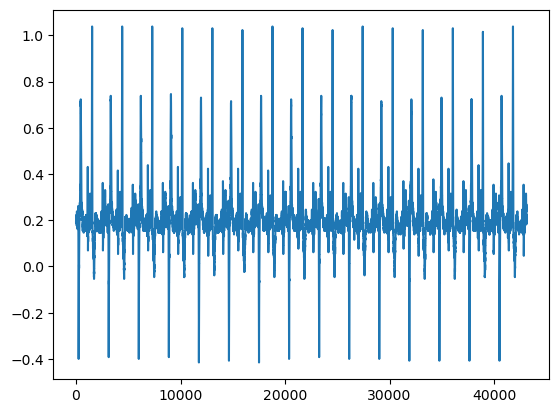

Record: aami3c
Sampling frequency: 720 Hz
Number of channels: 1
Signal name: ['ECG']
Signal comments: ['ANSI/AAMI EC13-1992, Figure 3c.']



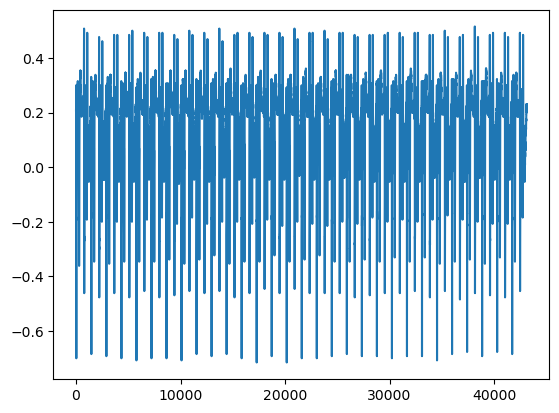

Record: aami3d
Sampling frequency: 720 Hz
Number of channels: 1
Signal name: ['ECG']
Signal comments: ['ANSI/AAMI EC13-1992, Figure 3d.']



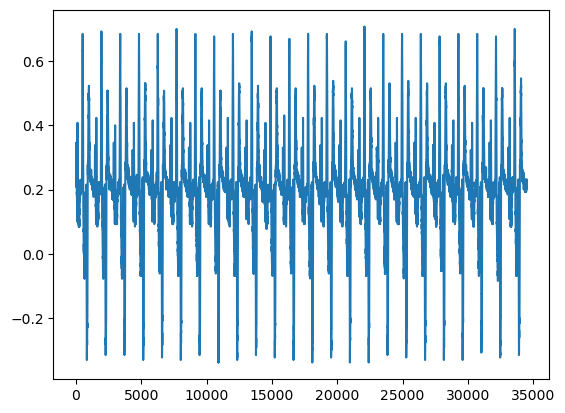

Record: aami4a
Sampling frequency: 720 Hz
Number of channels: 1
Signal name: ['ECG']
Signal comments: ['ANSI/AAMI EC13-1992, Figure 4a, 1x.']



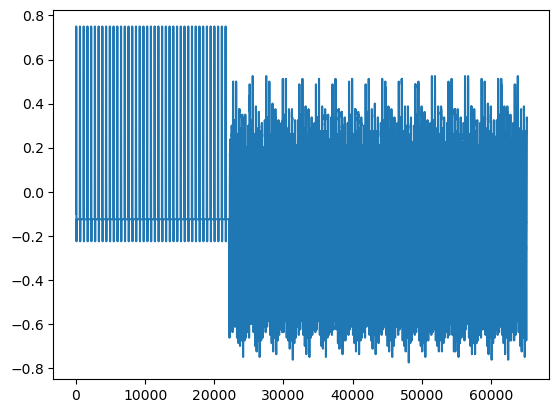

Record: aami4a_d
Sampling frequency: 720 Hz
Number of channels: 1
Signal name: ['ECG']
Signal comments: ['ANSI/AAMI EC13-1992, Figure 4a, 2x.']



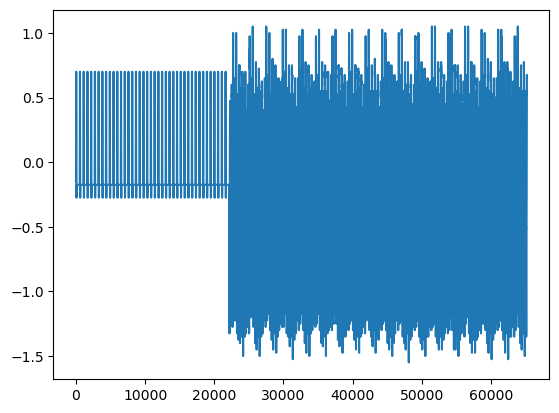

Record: aami4a_h
Sampling frequency: 720 Hz
Number of channels: 1
Signal name: ['ECG']
Signal comments: ['ANSI/AAMI EC13-1992, Figure 4a, 0.5x.']



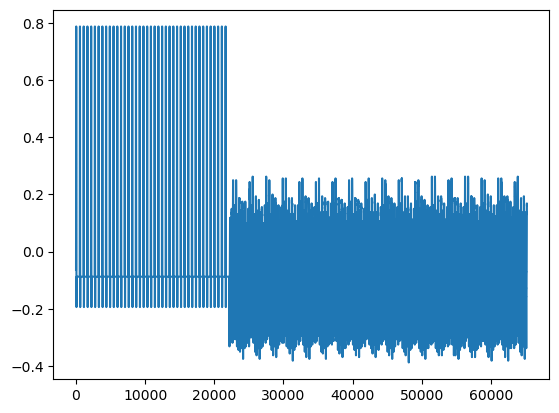

Record: aami4b
Sampling frequency: 720 Hz
Number of channels: 1
Signal name: ['ECG']
Signal comments: ['ANSI/AAMI EC13-1992, Figure 4b, 1x.']



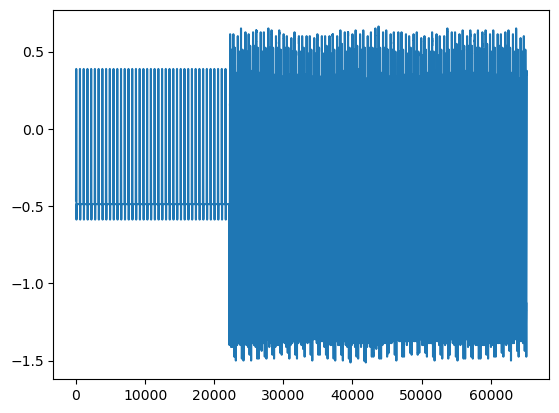

Record: aami4b_d
Sampling frequency: 720 Hz
Number of channels: 1
Signal name: ['ECG']
Signal comments: ['ANSI/AAMI EC13-1992, Figure 4b, 2x.']



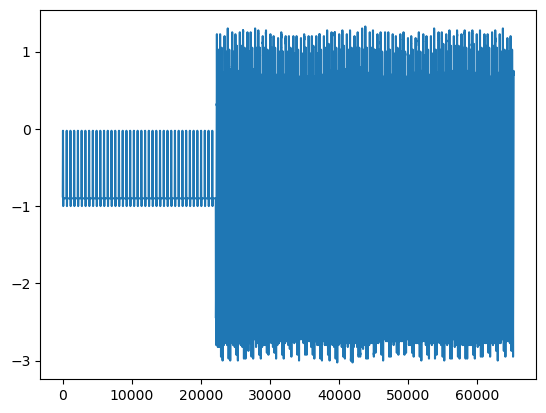

Record: aami4b_h
Sampling frequency: 720 Hz
Number of channels: 1
Signal name: ['ECG']
Signal comments: ['ANSI/AAMI EC13-1992, Figure 4b, 0.5x.']



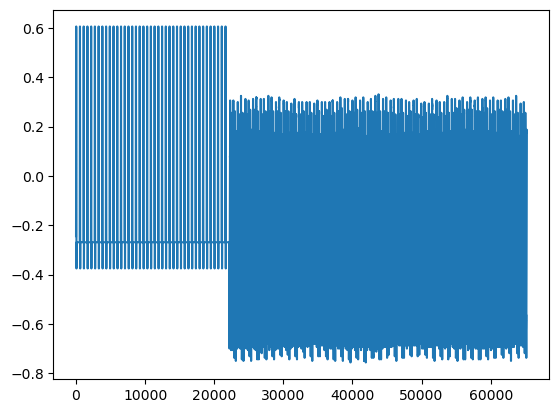

In [4]:
ecg_files = [f for f in os.listdir(datasetPath) if f.endswith('.dat')]

ecg_records = [None] * len(ecg_files)

for index, file in enumerate(ecg_files):
    # plot only first 4 records
    # if index >= 4:
    #     break
        
    record_name = os.path.splitext(file)[0]
    
    # record = wfdb.rdrecord(os.path.join(datasetPath, record_name))
    record2, fields = wfdb.rdsamp(os.path.join(datasetPath, record_name))
    
    ecg_records[index] = record2
    
    # display information about record
    print(f"Record: {record_name}")
    printECGDetails(fields)
    
    # plot signal
    # wfdb.plot_wfdb(record=record2, title=f"ECG Record: {record_name}", figsize=(10, 5))
    plotECGSignal(record2)

# Calculate frequency spectrum

In [21]:
import numpy as np
from scipy import signal
from scipy.fft import fft
import matplotlib.pyplot as plt

### PTBXL ECG Filtering Methods

In [34]:
def butterworth_highpass(data = 0, cutoff = 0.5, fs = 500, order = 4):
  nyquist = 0.5 * fs
  normal_cutoff = cutoff / nyquist
  b, a = signal.butter(order, normal_cutoff, btype = "highpass")
  y = signal.lfilter(b, a, data)

  return y

def butterworth_lowpass(data = 0, cutoff = 200, fs = 500, order = 4):
  nyquist = 0.5 * fs
  normal_cutoff = cutoff / nyquist
  b, a = signal.butter(order, normal_cutoff, btype = "lowpass", analog=False)
  
  if len(data.shape) == 1:
      axis = 0
  else:
        axis = 1
  y = signal.lfilter(b, a, data, axis=axis)

  return y

### Apply filters

In [7]:
highpassFilteredRecords = [None] * len(ecg_records)
lowpassFilteredRecords = [None] * len(ecg_records)
savitzkyGolayFilteredRecords = [None] * len(ecg_records)
datatsetFFTRecords = [None] * len(ecg_records)

for index, record in enumerate(ecg_records):
    # highpass filter
    # highpassFilteredRecords[index] = butterworth_highpass(data=record.p_signal[:, 0], cutoff=0.5, fs=record.fs, order=4)
    highpassFilteredRecords[index] = butterworth_highpass(data=ecg_records[index], cutoff=0.5, fs=720, order=4)
    
    # lowpassFilteredRecords[index] = butterworth_lowpass(data=highpassFilteredRecords[index], cutoff=200, fs=record.fs, order=4)
    lowpassFilteredRecords[index] = butterworth_lowpass(data=highpassFilteredRecords[index], cutoff=200, fs=720, order=4)
    # 
    # # savitzkyGolayFilteredRecords[index] = signal.savgol_filter(lowpassFilteredRecords[index], window_length=5, polyorder=2)
    savitzkyGolayFilteredRecords[index] = signal.savgol_filter(lowpassFilteredRecords[index].squeeze(), window_length=31, polyorder=3)
    
    datatsetFFTRecords[index] = fft(savitzkyGolayFilteredRecords[index])

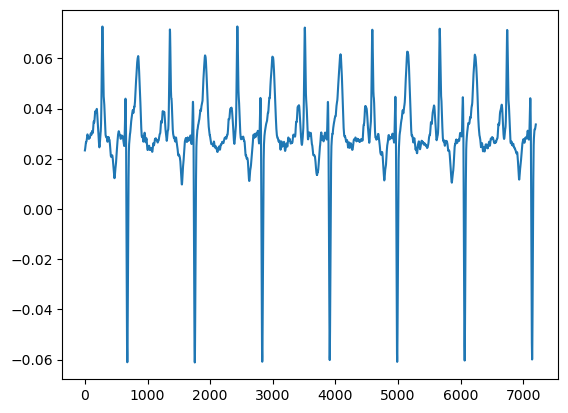

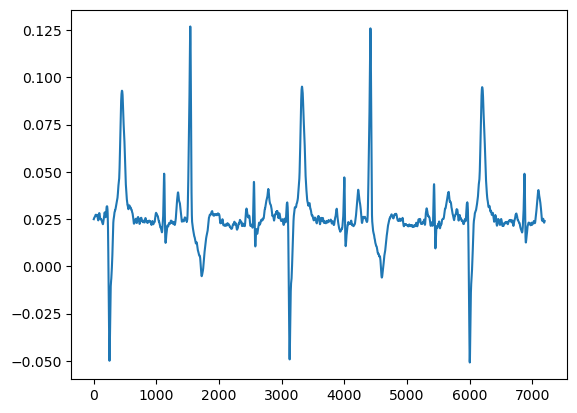

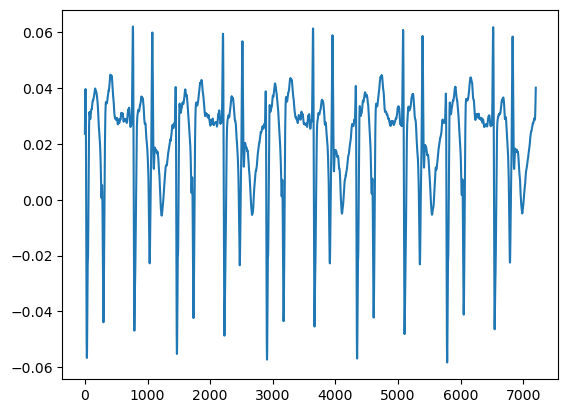

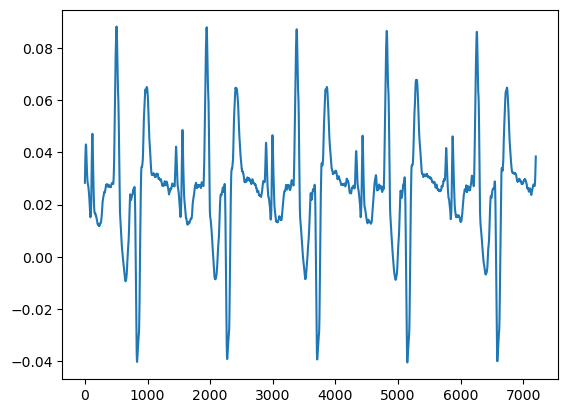

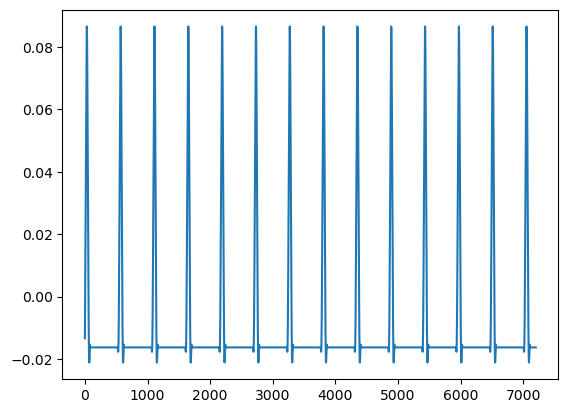

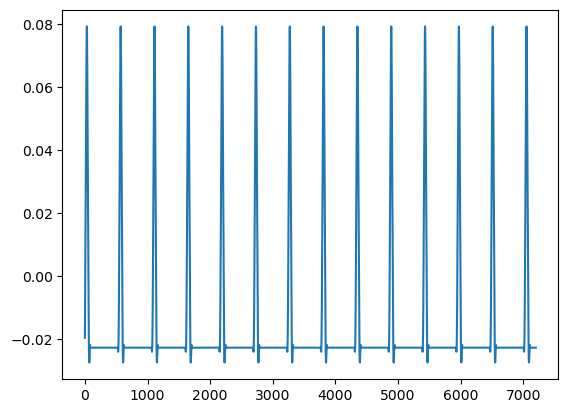

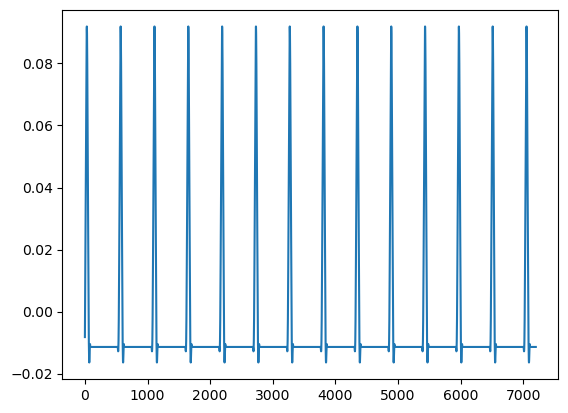

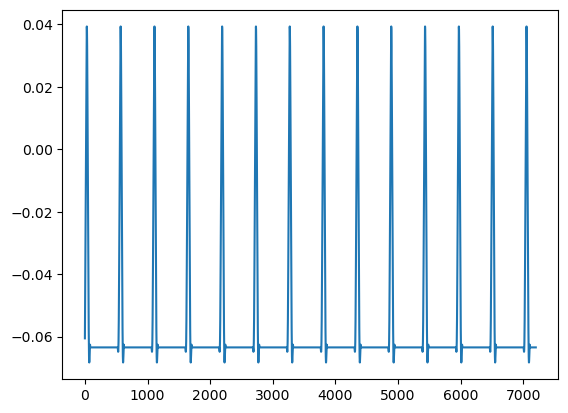

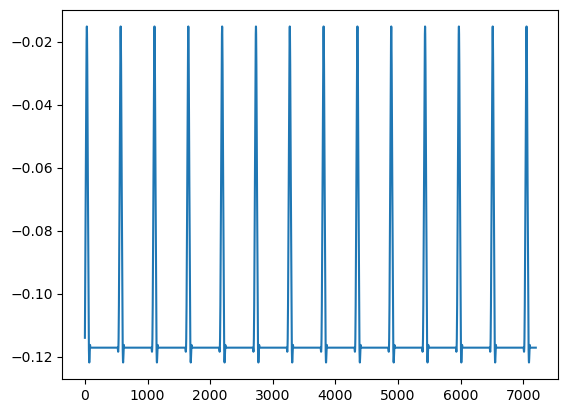

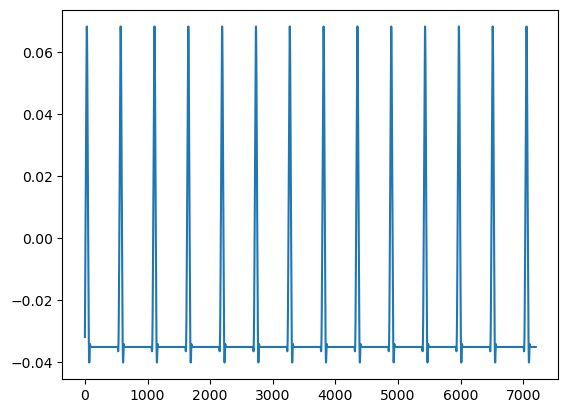

In [18]:
for rec in savitzkyGolayFilteredRecords:
    plotECGSignal(rec[:720*10])

### Obtain Frequency Spectrum

In [9]:
def calculateFrequencySpectrum(data, fs, title='Message'):
    N = len(data)
    freqs = np.fft.fftfreq(N, 1/fs)
    
    print('N: ', N)
    print('freqs: ', freqs)    
    
    plt.plot(freqs[:N//2], np.abs(data)[:N//2])
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()

N:  43081
freqs:  [ 0.          0.0167127   0.03342541 ... -0.05013811 -0.03342541
 -0.0167127 ]


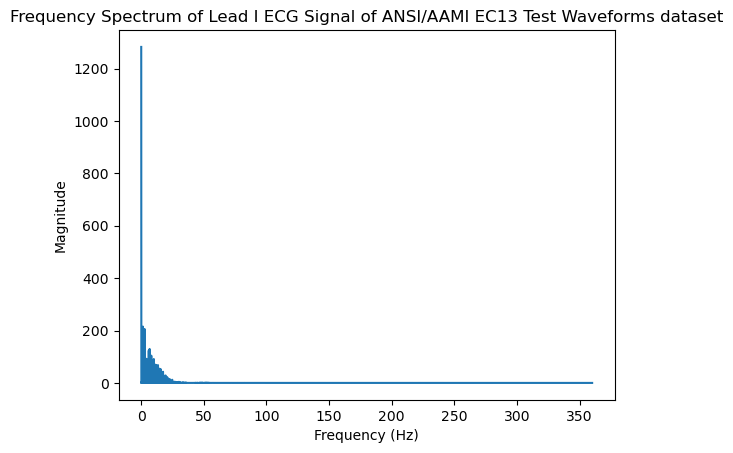

N:  43142
freqs:  [ 0.          0.01668907  0.03337815 ... -0.05006722 -0.03337815
 -0.01668907]


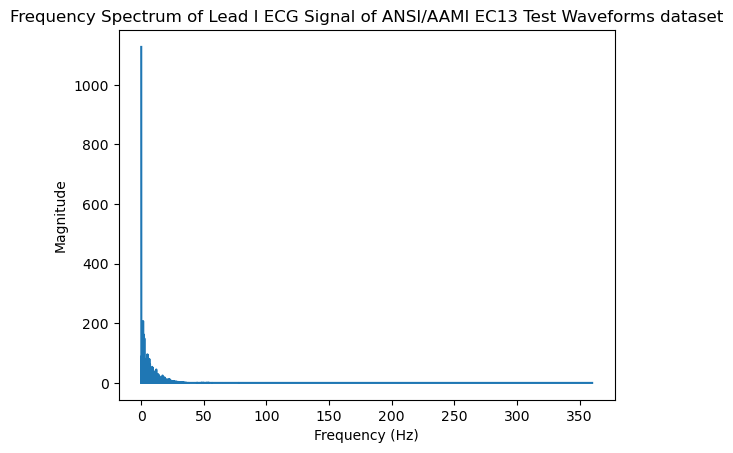

N:  43144
freqs:  [ 0.         0.0166883  0.0333766 ... -0.0500649 -0.0333766 -0.0166883]


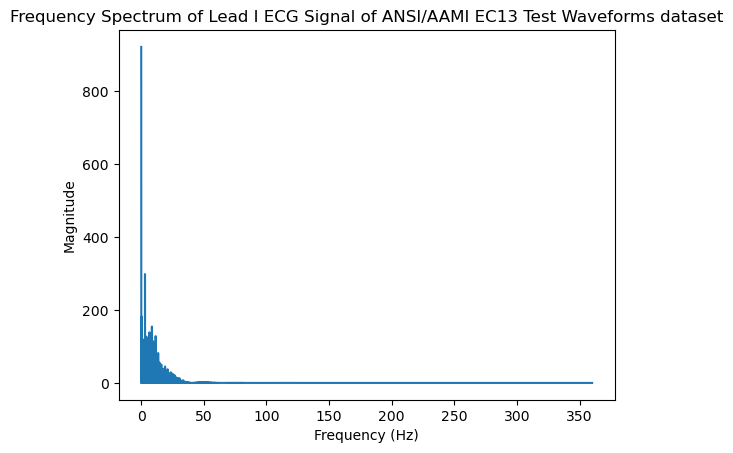

N:  34511
freqs:  [ 0.          0.02086291  0.04172583 ... -0.06258874 -0.04172583
 -0.02086291]


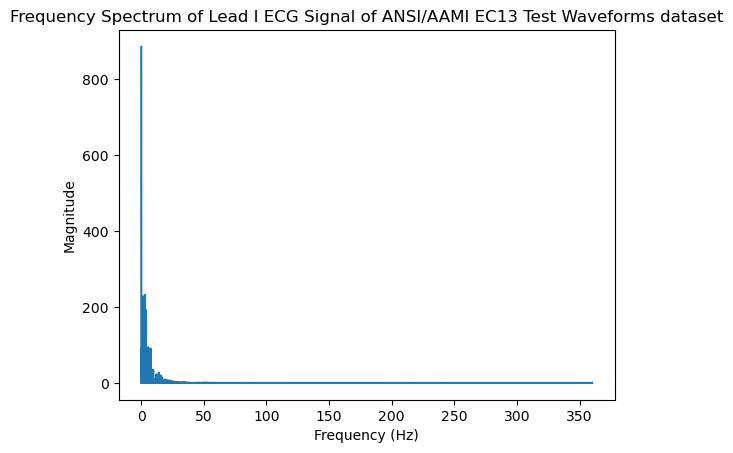

N:  65211
freqs:  [ 0.          0.01104108  0.02208216 ... -0.03312325 -0.02208216
 -0.01104108]


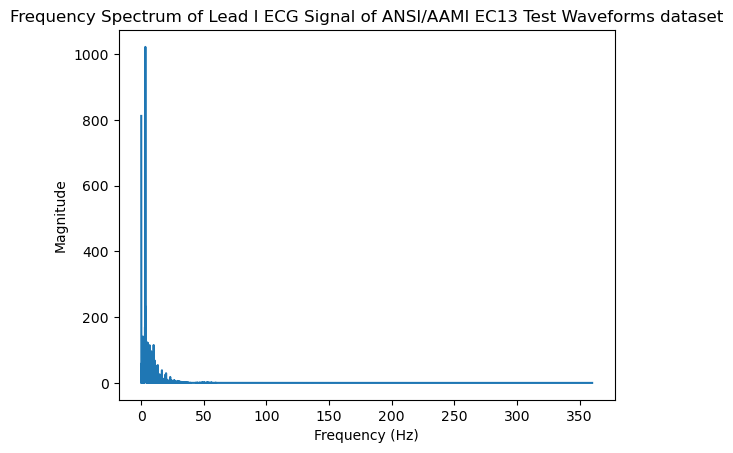

N:  65214
freqs:  [ 0.          0.01104057  0.02208115 ... -0.03312172 -0.02208115
 -0.01104057]


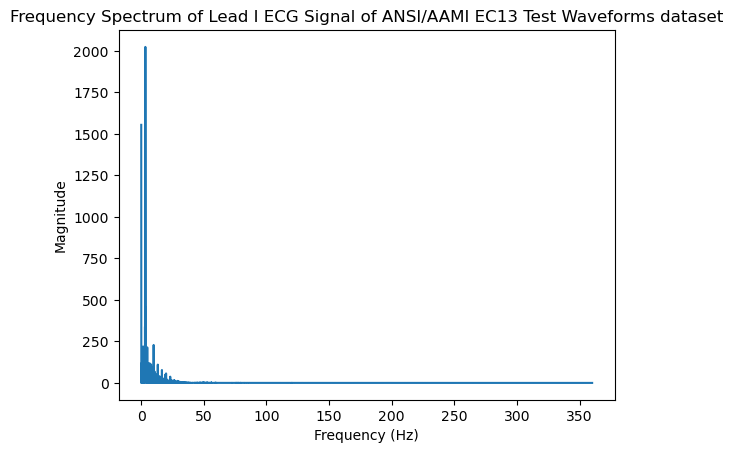

N:  65207
freqs:  [ 0.          0.01104176  0.02208352 ... -0.03312528 -0.02208352
 -0.01104176]


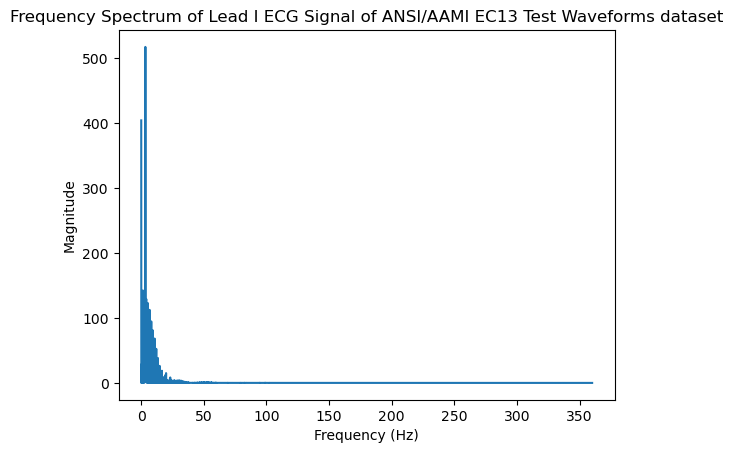

N:  65238
freqs:  [ 0.          0.01103651  0.02207302 ... -0.03310954 -0.02207302
 -0.01103651]


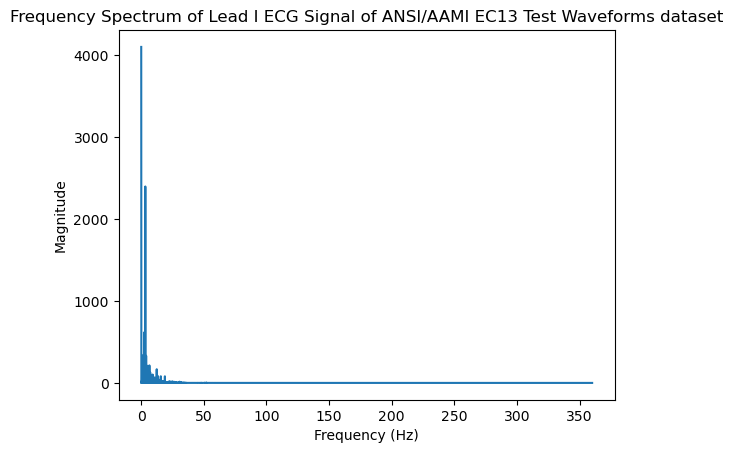

N:  65239
freqs:  [ 0.          0.01103634  0.02207269 ... -0.03310903 -0.02207269
 -0.01103634]


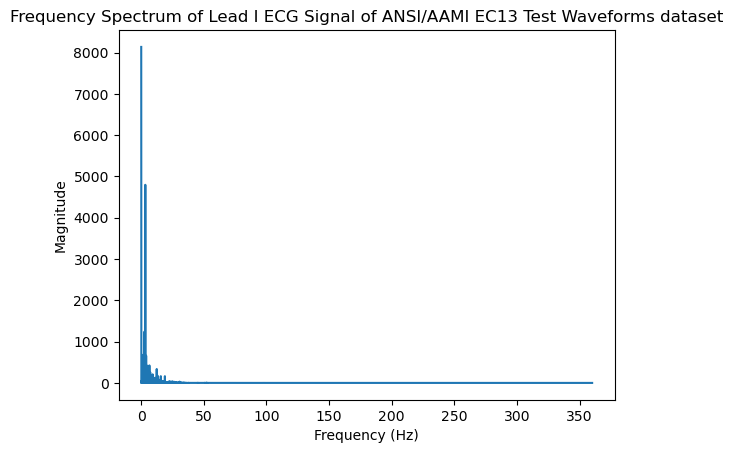

N:  65237
freqs:  [ 0.          0.01103668  0.02207336 ... -0.03311004 -0.02207336
 -0.01103668]


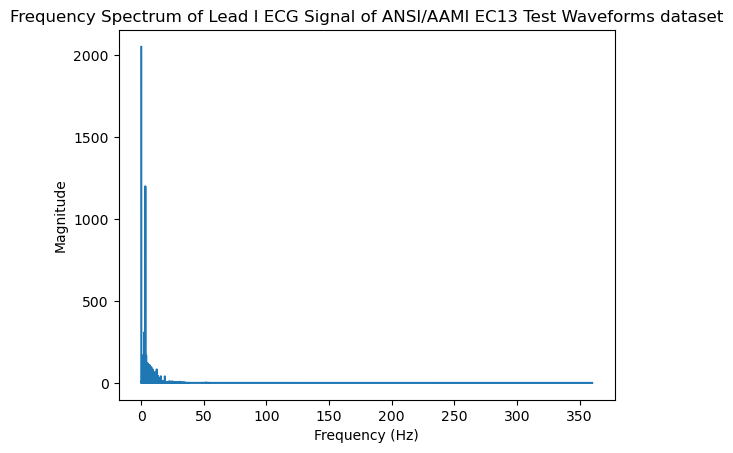

In [49]:
for index, record in enumerate(datatsetFFTRecords):
    calculateFrequencySpectrum(record, 720, 'Frequency Spectrum of ECG Signal - ANSI/AAMI EC13 Test Waveforms dataset')

# Obtaining Frequency Spectrum of Lead I ECG Signal obtained from device

In [11]:
deviceReadingsPath = r"C:\Users\USER\Documents\SLIIT\Projects\CardioFit-AI Model\Palm Analysis\Sample ECG"

In [12]:
deviceEcgFiles = [f for f in os.listdir(deviceReadingsPath) if f.endswith('.txt')]

In [13]:
deviceEcgFiles

['12raw2000.txt',
 '12rawUpsampled5000.txt',
 '12rawUpsampledFiltered2_5000_reshaped.txt',
 '12rawUpsampledFiltered3_5000_reshaped.txt',
 '12rawUpsampledFiltered5000.txt',
 '14raw2000.txt',
 '14rawUpsampled5000.txt',
 '14rawUpsampledFiltered2_5000_reshaped.txt',
 '14rawUpsampledFiltered3_5000_reshaped.txt',
 '14rawUpsampledFiltered5000.txt',
 '15raw2000.txt',
 '15rawUpsampled5000.txt',
 '15rawUpsampledFiltered2_5000_reshaped.txt',
 '15rawUpsampledFiltered3_5000_reshaped.txt',
 '15rawUpsampledFiltered5000.txt',
 '16raw2000.txt',
 '16rawUpsampled5000.txt',
 '16rawUpsampledFiltered2_5000_reshaped.txt',
 '16rawUpsampledFiltered3_5000_reshaped.txt',
 '16rawUpsampledFiltered5000.txt',
 '18raw2000.txt',
 '18rawUpsampled5000.txt',
 '18rawUpsampledFiltered2_5000_reshaped.txt',
 '18rawUpsampledFiltered3_5000_reshaped.txt',
 '18rawUpsampledFiltered5000.txt',
 '1raw2000.txt',
 '1rawUpsampled5000.txt',
 '1rawUpsampledFiltered2_5000_reshaped.txt',
 '1rawUpsampledFiltered3_5000_reshaped.txt',
 '1rawU

In [60]:
recordCount = 0

# check how many files are actually being read
for index, file in enumerate(deviceEcgFiles):
    if file.endswith('raw2000.txt'):
        recordCount += 1

# create a list to store all the records
deviceEcgRecords = [None] * recordCount

count = -1

# read only files that end with 'raw2000.txt' and store them in a list
for index, file in enumerate(deviceEcgFiles):    
    if file.endswith('raw2000.txt'):     
        # if count > 10:
        #     break
            
        count += 1
        
        record_name = os.path.splitext(file)[0]
        record = np.loadtxt(os.path.join(deviceReadingsPath, record_name + ".txt"))        
        deviceEcgRecords[count] = record
        
        # display information about record
        print(f"Record: {record_name}")
        
        # plot signal
        # plotECGSignal(deviceEcgRecords[index])

Total number of ECG files: 14
(2000,)
Record: 12raw2000
(2000,)
Record: 14raw2000
(2000,)
Record: 15raw2000
(2000,)
Record: 16raw2000
(2000,)
Record: 18raw2000
(2000,)
Record: 1raw2000
(2000,)
Record: 21raw2000
(2000,)
Record: 2raw2000
(2000,)
Record: 3raw2000
(2000,)
Record: 4raw2000
(2000,)
Record: 5raw2000
(2000,)
Record: 6raw2000
(2000,)
Record: 7raw2000
(2000,)
Record: 9raw2000


In [63]:
len(deviceEcgRecords)

14

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


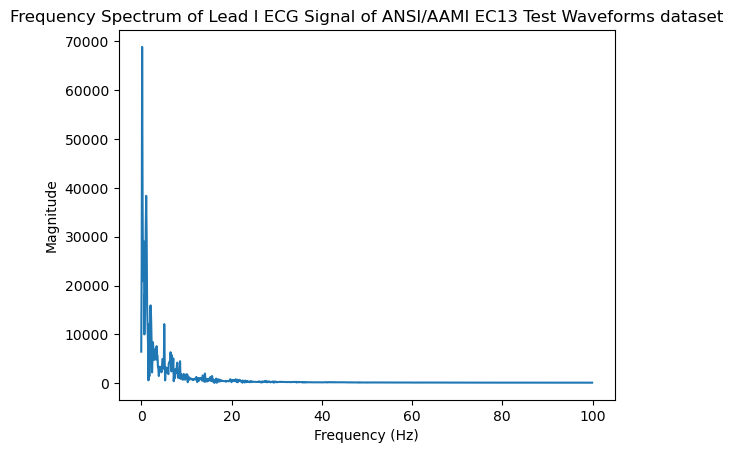

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


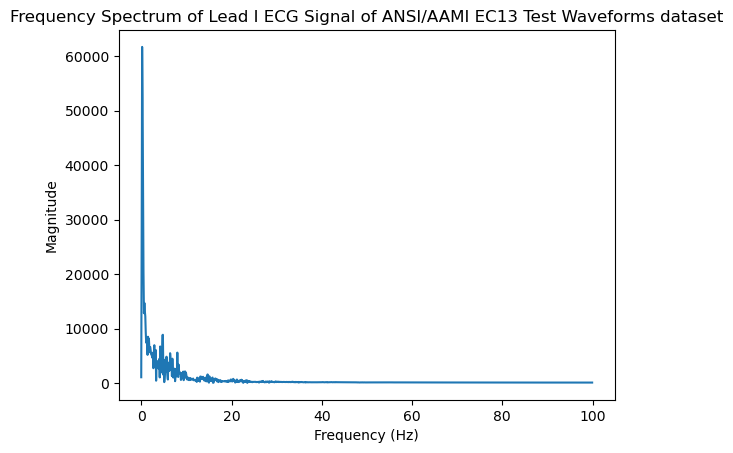

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


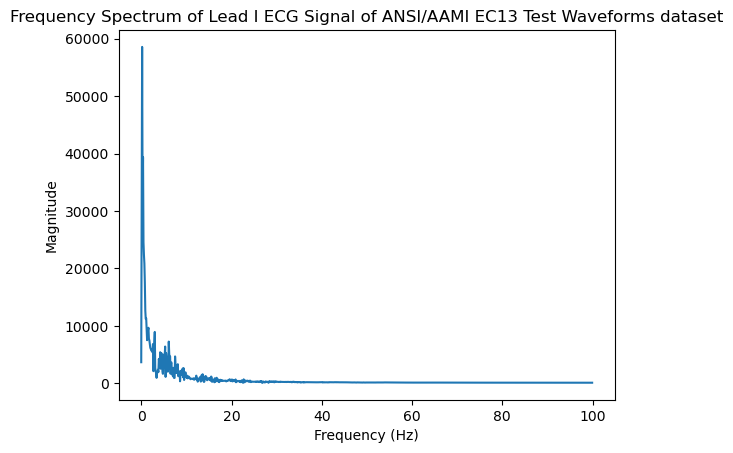

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


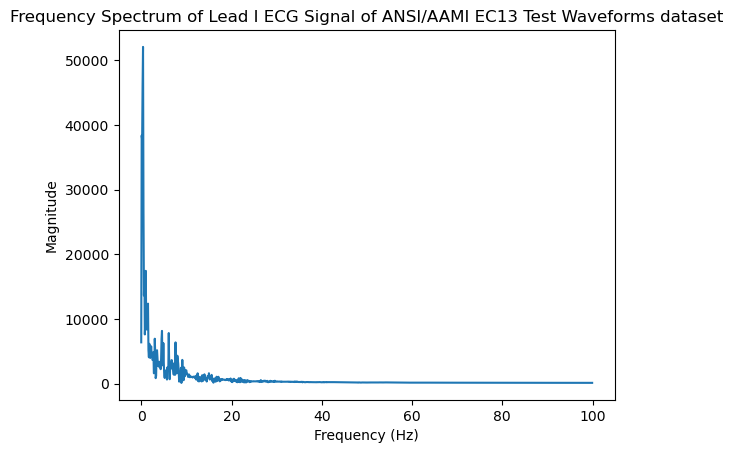

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


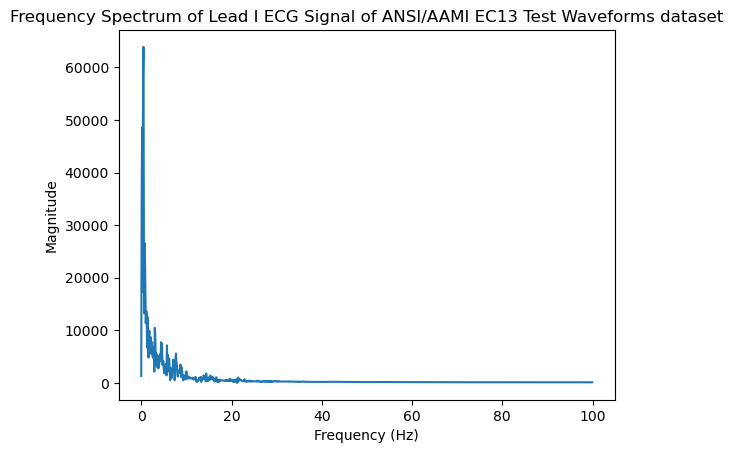

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


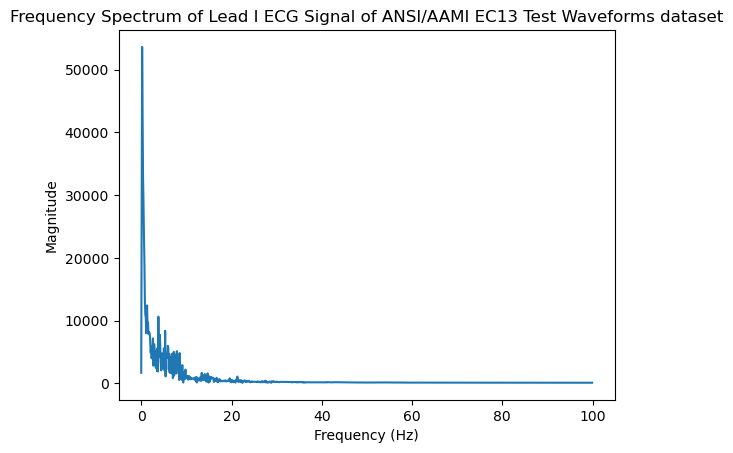

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


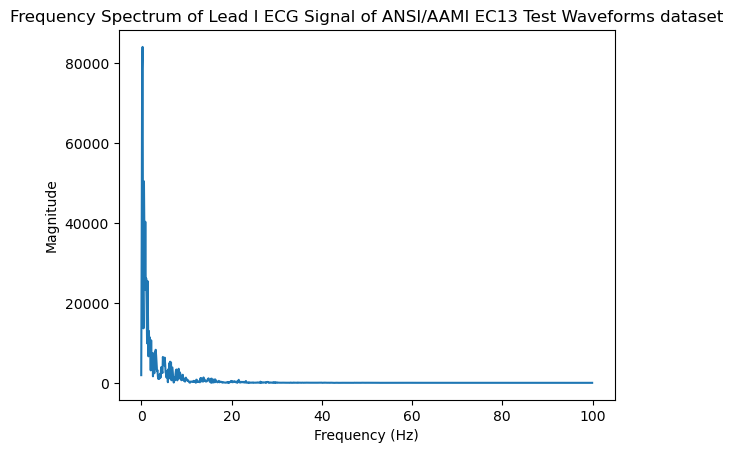

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


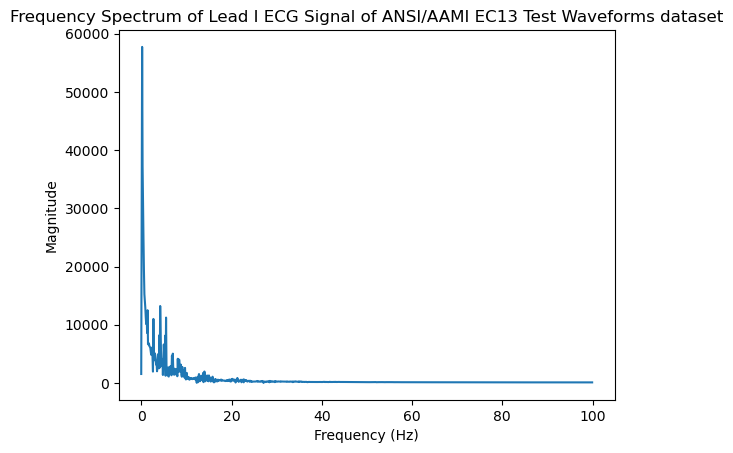

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


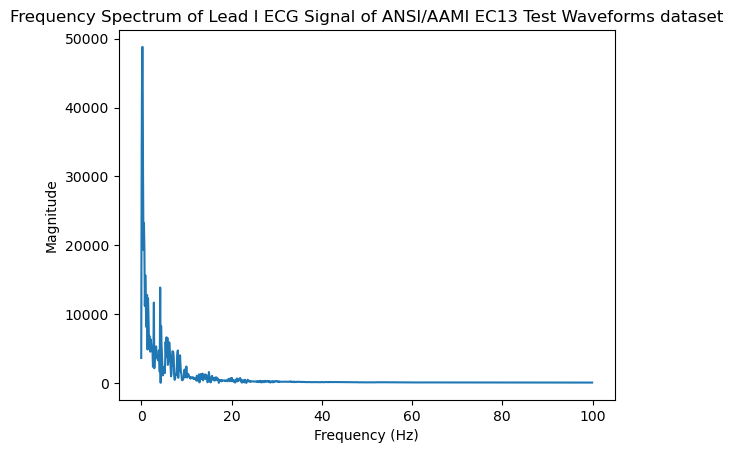

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


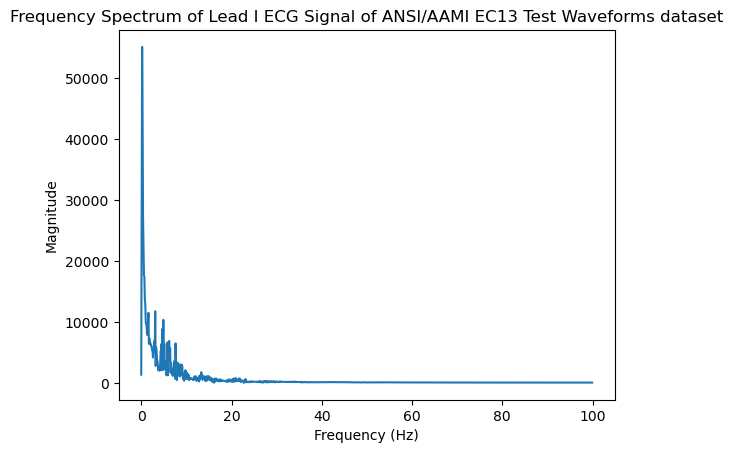

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


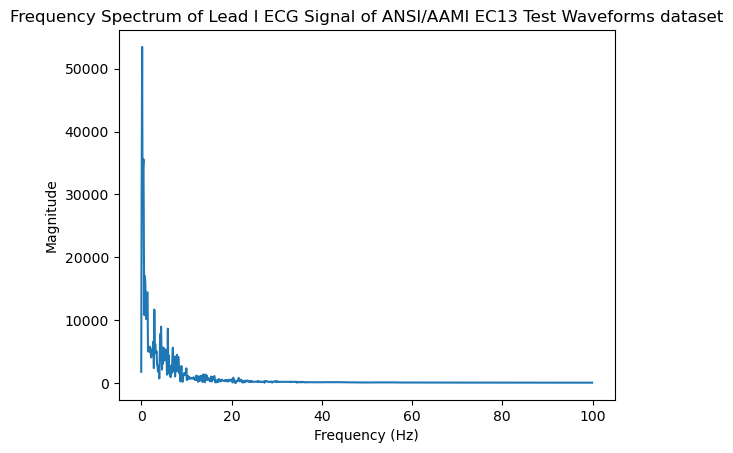

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


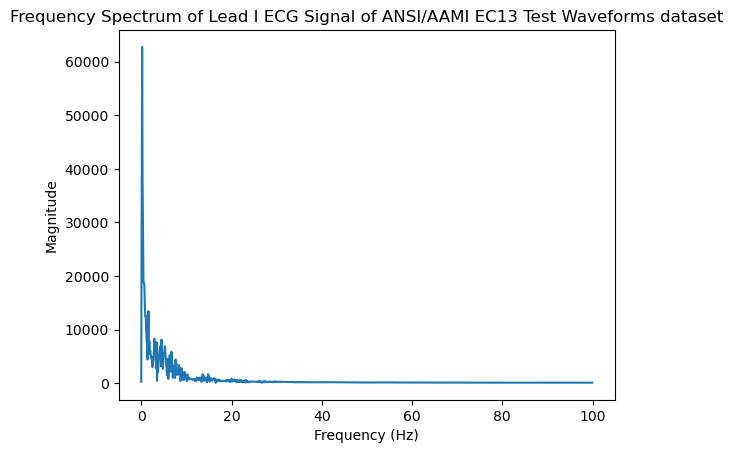

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


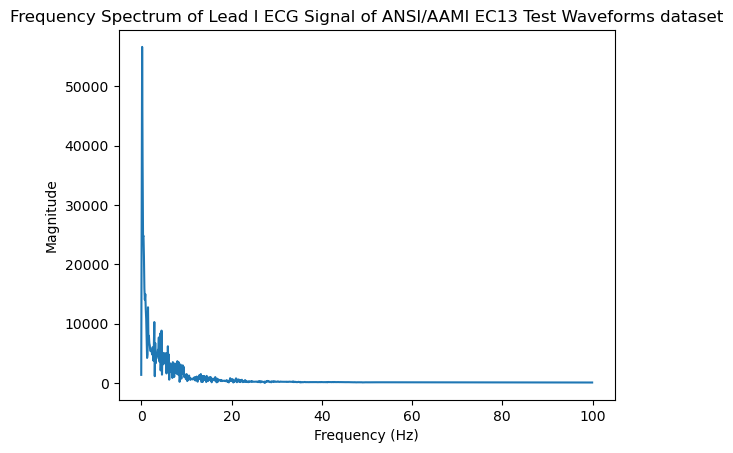

N:  2000
freqs:  [ 0.   0.1  0.2 ... -0.3 -0.2 -0.1]


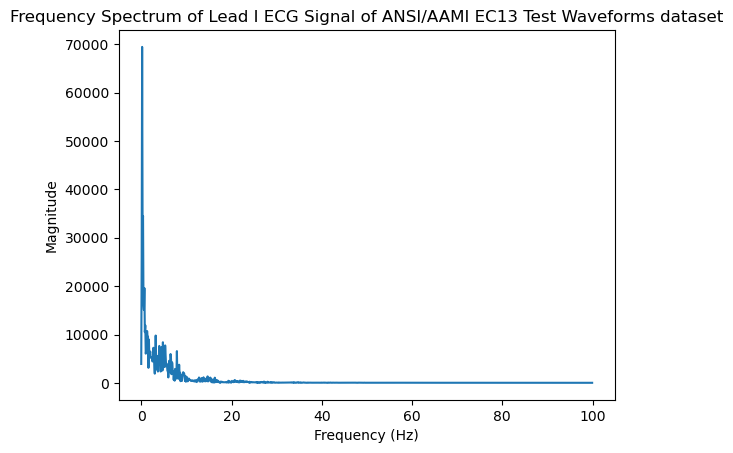

In [65]:
deviceHighpassRecords = [None] * len(deviceEcgRecords)
deviceLowpassRecords = [None] * len(deviceEcgRecords)
deviceSavitzkyRecords = [None] * len(deviceEcgRecords)
deviceFFTRecords = [None] * len(deviceEcgRecords)

for index, record in enumerate(deviceEcgRecords):
    # highpass filter
    deviceHighpassRecords[index] = butterworth_highpass(data=deviceEcgRecords[index], cutoff=0.5, fs=720, order=4)
    
    deviceLowpassRecords[index] = butterworth_lowpass(data=deviceHighpassRecords[index], cutoff=200, fs=720, order=4)
    
    deviceSavitzkyRecords[index] = signal.savgol_filter(deviceLowpassRecords[index].squeeze(), window_length=31, polyorder=3)
    
    deviceFFTRecords[index] = fft(deviceSavitzkyRecords[index])
    
    calculateFrequencySpectrum(deviceFFTRecords[index], 200, 'Frequency Spectrum of Lead I ECG Signal - Device')